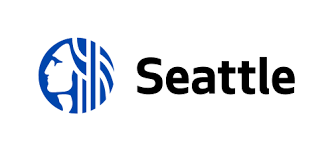

### Anticiper les besoins en consommation de bâtiments - Prédiction des émissions de CO2

### Sommaire


* [1. Importation des librairies, définition des fonctions et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Définition des fonctions](#1_2)
    * [1.3 Importation du fichier](#1_3)
* [2. Preprocessing](#2)
    * [2.1 Matrice X des données et vecteur y des cibles](#2_1)
    * [2.2 Division en train set et test set](#2_2)
* [3. Modelisation](#3)
    * [3.1 Dummy regressor (Baseline)](#3_1)
    * [3.2 Régression linéaire](#3_2)
    * [3.3 Régression ridge](#3_3)
    * [3.4 Lasso](#3_4)
    * [3.5 Elastic net](#3_5)
    * [3.6 Linear SVR](#3_6)
    * [3.7 Forêts aléatoires](#3_7)
    * [3.8  XGBoost](#3_8)
* [4. Choix du modèle](#4)
    * [4.1  Affichage des scores](#4_1)
    * [4.2 Comparaison des scores obtenus](#4_2)
    * [4.3  Comparaison par le coefficient de détermination](#4_3)
    * [4.4  Comparaison par l'erreur](#4_4)
    * [4.5  Comparaison par le temps d'exécution](#4_5)
    * [4.6 Courbe d'apprentissage sur le XGBoost](#4_6)
* [5. Evaluation de l'intérêt de l'ENERGY STAR score pour la prédiction](#5)
    * [5.1 Preprocessing](#5_1)
    * [5.2 Modélisation du XGBoost avec l'ENERGY STAR score](#5_2)
    * [5.3 Comparaison des scores avec ou sans ENERGY STAR score](#5_3)
* [6. Importance des caractéristiques (Features importance)](#6)
* [7. Enregistrement du modèle](#7)

## 1. Importation des librairies, définition des fonctions et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# data
import pandas as pd
import numpy as np
from numpy import log1p, exp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Temps d'exécution
import time

# Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# Interprétabilité
import shap
shap.initjs() # Initialisation du Javascript

# Améliorer le temps d'exécution
from joblib import parallel_backend

# Pour le stockage du modèle
import pickle

### 1.2 Définition des fonctions <a class="anchor" id="1_2"></a>

In [2]:
def final_pipeline(X, model, params):
    variables_quantitatives = X.select_dtypes(['int64','float64']).columns.to_list()
    variables_qualitatives = X.select_dtypes(['object','bool']).columns.to_list()
    quantitatif_scaler = StandardScaler()
    qualitatif_encoder = OneHotEncoder(handle_unknown='ignore')
    transformers = [('qualitatif', qualitatif_encoder, variables_qualitatives), 
                    ('quantitatif', quantitatif_scaler, variables_quantitatives)]
    preparation = ColumnTransformer(transformers)
    model_pipeline = make_pipeline(preparation, model) 
    grid = GridSearchCV(model_pipeline, 
                        params, 
                        cv=5, 
                        scoring='r2', 
                        n_jobs=-1)
    
    return grid

def bestParams(model):
    """Afficher les meilleurs paramètres, et le meilleur score"""
    best_params = model.best_params_
    print('Les meilleurs paramètres sont :')
    print(best_params)

def affichage_résultats(model):
    """Dataframe présentant les résultats du modèle"""
    # Résultats de la recherche sur grille
    résultats = pd.DataFrame(model.cv_results_)
    colonnes = [i for i in résultats.columns if 'split' not in i]
    résultats = résultats[colonnes]
    
    # Trier les résultats en fonction du classement du test
    résultats = résultats.sort_values('rank_test_score')
    
    return résultats.head(10)

# Créer un DataFrame vide pour stocker les résultats des modèles
df_results = pd.DataFrame(columns=['Model', 'R2_train', 'R2_test', 'MAE_test', 'RMSE_test', "Temps d'exécution"])

def score(model, X_train, y_train, X_test, y_test, model_name, execution_time, df_results):
    """Fonction pour calculer et ajouter les scores R2, MAE et RMSE dans le DataFrame"""
    y_train_pred = model.best_estimator_.predict(X_train)  # Prédictions sur l'ensemble d'entraînement
    y_test_pred = model.best_estimator_.predict(X_test)    # Prédictions sur l'ensemble de test
    
    R2_train = round(metrics.r2_score(y_train, y_train_pred), 2)
    R2_test = round(metrics.r2_score(y_test, y_test_pred), 2)
    
    # Appliquer np.exp aux prédictions de l'ensemble de test
    y_test_pred = np.exp(y_test_pred)
    
    MAE_test = round(metrics.mean_absolute_error(np.exp(y_test), y_test_pred), 2)
    MSE_test = round(metrics.mean_squared_error(np.exp(y_test), y_test_pred), 2)
    RMSE_test = round(np.sqrt(MSE_test), 2)
    
    # Ajouter les résultats du modèle au DataFrame global en supprimant les potentiels doublons
    df_results.loc[df_results.shape[0]] = [model_name, R2_train, R2_test, MAE_test, RMSE_test, execution_time]
    df_results = df_results.drop_duplicates(subset=['Model'])

    return df_results
    
def visualisation_erreur(y_pred_train, y_train, y_pred_test, y_test):
    """Fonction pour afficher un scatter plot pour visualiser les erreurs de prédictions
    du train set et du test set"""
    plt.figure(figsize=(5,8))

    plt.subplot(2,1,1)
    plt.title("Visualisation de l'erreur des prédictions sur le train set", fontweight='bold')
    plt.scatter(np.exp(y_pred_train), np.exp(y_train))  # Convertir en l'exponentiel
    y_min, y_max = np.exp(min(y_train)), np.exp(max(y_train))
    plt.plot([y_min, y_max], [y_min, y_max], color='red')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Valeurs cibles')
    
    plt.subplot(2,1,2)
    plt.title("Visualisation de l'erreur des prédictions sur le test set", fontweight='bold')
    plt.scatter(np.exp(y_pred_test), np.exp(y_test))  # Convertir en l'exponentiel
    y_min, y_max = np.exp(min(y_test)), np.exp(max(y_test))
    plt.plot([y_min, y_max], [y_min, y_max], color='red')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Valeurs cibles')

    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()

    plt.show()

### 1.3 Importation du fichier <a class="anchor" id="1_3"></a>

In [3]:
df = pd.read_csv('df_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1475 non-null   object 
 1   Neighborhood                     1475 non-null   object 
 2   NumberofBuildings                1475 non-null   float64
 3   NumberofFloors                   1475 non-null   int64  
 4   PropertyGFATotal                 1475 non-null   int64  
 5   PropertyGFAParking               1475 non-null   int64  
 6   LargestPropertyUseType           1475 non-null   object 
 7   LargestPropertyUseTypeGFA        1475 non-null   float64
 8   SecondLargestPropertyUseType     1475 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1475 non-null   float64
 10  ThirdLargestPropertyUseType      1475 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1475 non-null   float64
 12  ENERGYSTARScore     

## 2. Preprocessing <a class="anchor" id="2"></a>

### 2.1 Matrice X des données et vecteur y des cibles <a class="anchor" id="2_1"></a>

In [4]:
# Instancier X et y
X = df.drop(['ENERGYSTARScore', 'TARGET_SiteEnergyUse(kBtu)', 'TARGET_TotalGHGEmissions'], axis=1)
y = df['TARGET_TotalGHGEmissions']

# Mettre y au log
log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
y_log = log_transformer.transform(y)

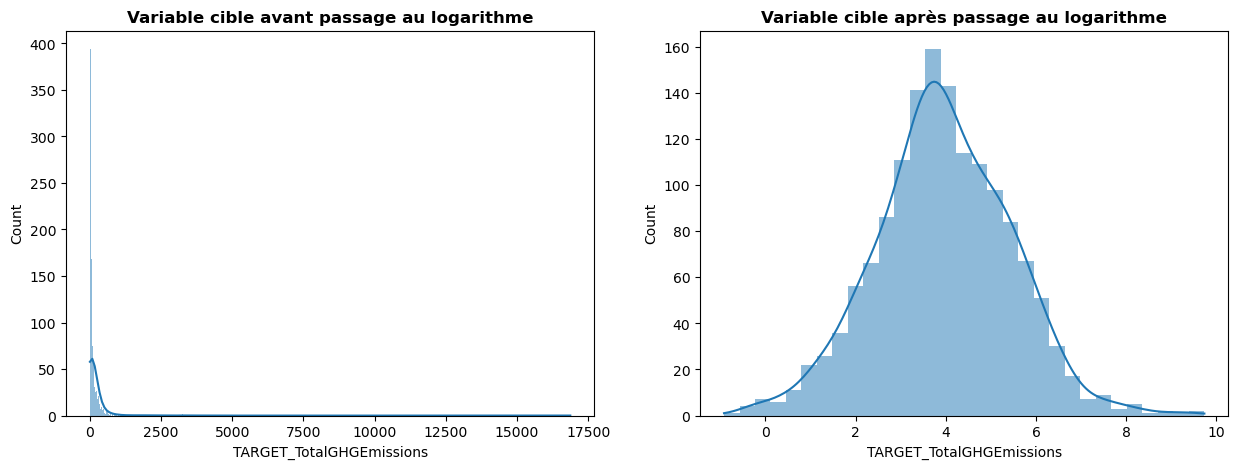

In [5]:
# Visualisation du preprocessing sur la variable cible
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(y, kde=True, edgecolor='none')
plt.title("Variable cible avant passage au logarithme", fontweight='bold')
plt.subplot(1,2,2)
sns.histplot(y_log, kde=True, edgecolor='none')
plt.title("Variable cible après passage au logarithme", fontweight='bold')
plt.show()

### 2.2 Division en train set et test set <a class="anchor" id="2_2"></a>

In [6]:
# On divise notre train set et test set
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, train_size=0.8, random_state=0)

# Vérifions la taille de notre train set et de notre test set
print(f'Nous avons X_train de forme {X_train.shape} et y_train_log de forme {y_train_log.shape}.')
print()
print(f'Nous avons X_test de forme {X_test.shape} et y_test_log de forme {y_test_log.shape}.')

Nous avons X_train de forme (1180, 16) et y_train_log de forme (1180,).

Nous avons X_test de forme (295, 16) et y_test_log de forme (295,).


## 3. Modelisation <a class="anchor" id="3"></a>

### 3.1 Dummy regressor (Baseline) <a class="anchor" id="3_1"></a>

In [7]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'dummyregressor__strategy': ['mean', 'median']
}

# utilisation de la fonction 'final_pipeline'
dummy_regressor = final_pipeline(X, DummyRegressor(), params)

# Entraînement du modèle
dummy_regressor.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA',
                                                                          'EraBuild',
                                                                          'SteamUse_Ratio',
                                                                          'ElectricityUse_Ratio',
                                                                          'NaturalGasUse_Ratio'])])),
                                       ('dummyregressor', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'dummyregressor__strategy': ['mean', 'median']},
             scoring='r2')

In [8]:
# Prédictions sur Train Set
y_pred_dummy_train = dummy_regressor.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_dummy_test = dummy_regressor.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
dummy_regressor_execution_time = time.time() - start_time

In [9]:
affichage_résultats(dummy_regressor)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dummyregressor__strategy,params,mean_test_score,std_test_score,rank_test_score
1,0.007802,0.000749,0.003601,0.000490,median,{'dummyregressor__strategy': 'median'},-0.013992,0.016274,1
0,0.009402,0.001357,0.003801,0.000748,mean,{'dummyregressor__strategy': 'mean'},-0.014309,0.011910,2


In [10]:
bestParams(dummy_regressor)

Les meilleurs paramètres sont :
{'dummyregressor__strategy': 'median'}


In [11]:
# Affichage des scores
score(dummy_regressor, X_train, y_train_log, X_test, y_test_log, 
      'Dummy Regressor', dummy_regressor_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Dummy Regressor']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
0,Dummy Regressor,-0.0,-0.01,188.14,600.15,0.003001


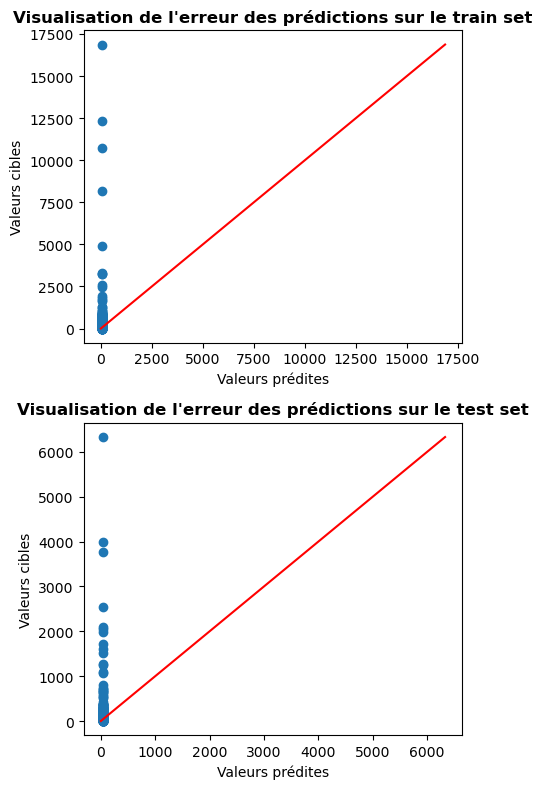

In [12]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_dummy_train, y_train_log, y_pred_dummy_test, y_test_log)

### 3.2 Régression linéaire <a class="anchor" id="3_2"></a>

In [13]:
# Créer un dictionnaire de paramètres
params = {
    'linearregression__fit_intercept': [True, False]
}

# utilisation de la fonction 'final_pipeline'
linear_regression = final_pipeline(X, LinearRegression(), params)

# Entraînement du modèle
linear_regression.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA',
                                                                          'EraBuild',
                                                                          'SteamUse_Ratio',
                                                                          'ElectricityUse_Ratio',
                                                                          'NaturalGasUse_Ratio'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__fit_intercept': [True, False]},
             scoring='r2')

In [14]:
# Prédictions
y_pred_linear_train = linear_regression.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_linear_test = linear_regression.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
linear_regression_execution_time = time.time() - start_time

In [15]:
affichage_résultats(linear_regression)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearregression__fit_intercept,params,mean_test_score,std_test_score,rank_test_score
0,0.015003,0.000633,0.003001,0.000000,True,{'linearregression__fit_intercept': True},0.598954,0.031432,1
1,0.019405,0.003073,0.004201,0.000749,False,{'linearregression__fit_intercept': False},0.597394,0.032718,2


In [16]:
bestParams(linear_regression)

Les meilleurs paramètres sont :
{'linearregression__fit_intercept': True}


In [17]:
# Affichage des scores
score(linear_regression, X_train, y_train_log, X_test, y_test_log, 
      'Linear Regression', linear_regression_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Linear Regression']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
1,Linear Regression,0.66,0.67,152.0,563.46,0.003


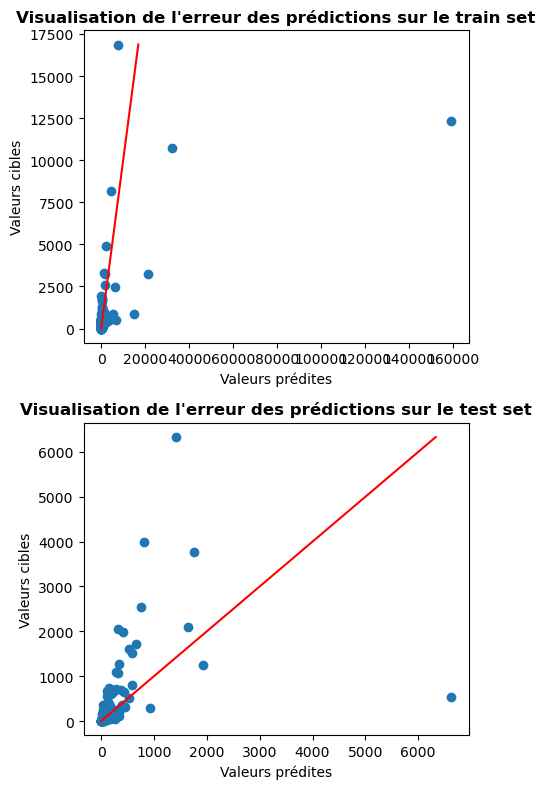

In [18]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_linear_train, y_train_log, y_pred_linear_test, y_test_log)

### 3.3 Régression ridge <a class="anchor" id="3_3"></a>

In [19]:
# Déterminons le paramètre alpha qui va contrôler le paramètre de régularisation (on va en tester 50)
# Ils seront sur une échelle logarithmique
alphas = np.logspace(-5, 5, 50)

# Créer un dictionnaire de paramètres
params = {
      'ridge__alpha': alphas,
}

# utilisation de la fonction 'final_pipeline'
ridge = final_pipeline(X, Ridge(), params)

# Entraînement du modèle
ridge.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
             scoring='r2')

In [20]:
# Prédictions
y_pred_ridge_train = ridge.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_ridge_test = ridge.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
ridge_execution_time = time.time() - start_time

In [21]:
affichage_résultats(ridge)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,mean_test_score,std_test_score,rank_test_score
30,0.015003,0.002530,0.005602,0.000800,13.257114,{'ridge__alpha': 13.257113655901108},0.609340,0.033546,1
31,0.012803,0.000400,0.005401,0.000490,21.209509,{'ridge__alpha': 21.209508879201927},0.609188,0.033181,2
29,0.014003,0.000633,0.005201,0.000400,8.286428,{'ridge__alpha': 8.286427728546842},0.608599,0.033519,3
32,0.013403,0.000800,0.005801,0.000749,33.932218,{'ridge__alpha': 33.9322177189533},0.607780,0.032398,4
28,0.014403,0.000490,0.005601,0.000491,5.179475,{'ridge__alpha': 5.1794746792312125},0.607307,0.033268,5
27,0.014603,0.000490,0.005601,0.000490,3.237458,{'ridge__alpha': 3.2374575428176464},0.605754,0.032857,6
33,0.013003,0.001265,0.005801,0.000748,54.286754,{'ridge__alpha': 54.286754393238596},0.604707,0.031264,7
26,0.015403,0.000490,0.005402,0.000490,2.02359,{'ridge__alpha': 2.0235896477251556},0.604134,0.032478,8
25,0.015803,0.000400,0.005601,0.000490,1.264855,{'ridge__alpha': 1.2648552168552958},0.602771,0.032125,9
24,0.017204,0.000980,0.005801,0.001327,0.790604,{'ridge__alpha': 0.7906043210907702},0.601683,0.031911,10


In [22]:
bestParams(ridge)

Les meilleurs paramètres sont :
{'ridge__alpha': 13.257113655901108}


In [23]:
# Affichage des scores
score(ridge, X_train, y_train_log, X_test, y_test_log, 
      'Ridge', ridge_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Ridge']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
2,Ridge,0.66,0.67,154.07,571.87,0.003001


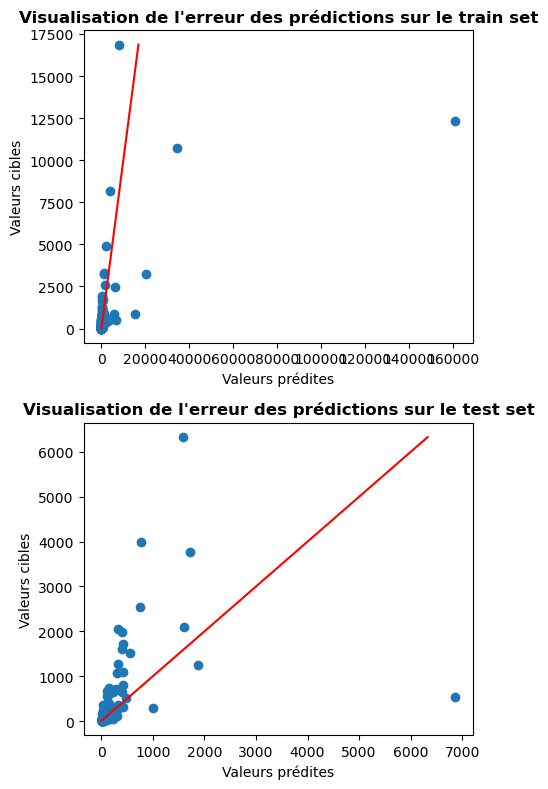

In [24]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_ridge_train, y_train_log, y_pred_ridge_test, y_test_log)

### 3.4 Lasso <a class="anchor" id="3_4"></a>

In [25]:
# Déterminons le paramètre alpha qui va contrôler le paramètre de régularisation (on va en tester 50)
# Ils seront sur une échelle logarithmique
alphas = np.logspace(-5, 5, 100)

# Créer un dictionnaire de paramètres
params = {
      'lasso__alpha': alphas,
}

# utilisation de la fonction 'final_pipeline'
lasso = final_pipeline(X, Lasso(), params)

# Entraînement du modèle
lasso.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])},
             scoring='r2')

In [26]:
# Prédictions
y_pred_lasso_train = lasso.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_lasso_test = lasso.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
lasso_execution_time = time.time() - start_time

In [27]:
affichage_résultats(lasso)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,mean_test_score,std_test_score,rank_test_score
27,0.021205,0.003764,0.005401,0.000490,0.005337,{'lasso__alpha': 0.005336699231206307},0.611759,0.029344,1
28,0.022605,0.003262,0.005401,0.000490,0.006734,{'lasso__alpha': 0.006734150657750821},0.611701,0.028528,2
26,0.022605,0.003383,0.005001,0.000633,0.004229,{'lasso__alpha': 0.0042292428743894986},0.611380,0.029948,3
29,0.021405,0.003073,0.005001,0.000632,0.008498,{'lasso__alpha': 0.008497534359086439},0.610861,0.028821,4
25,0.024605,0.003263,0.006202,0.000980,0.003352,{'lasso__alpha': 0.003351602650938841},0.610545,0.030512,5
24,0.025606,0.003007,0.005601,0.000490,0.002656,{'lasso__alpha': 0.0026560877829466868},0.609560,0.030986,6
23,0.026805,0.003710,0.004801,0.000748,0.002105,{'lasso__alpha': 0.00210490414451202},0.608614,0.031137,7
30,0.018804,0.001167,0.005201,0.000400,0.010723,{'lasso__alpha': 0.010722672220103232},0.608501,0.029296,8
22,0.028006,0.006420,0.006602,0.002245,0.001668,{'lasso__alpha': 0.0016681005372000592},0.607434,0.031229,9
21,0.030007,0.003848,0.004801,0.000400,0.001322,{'lasso__alpha': 0.0013219411484660286},0.606066,0.031209,10


In [28]:
bestParams(lasso)

Les meilleurs paramètres sont :
{'lasso__alpha': 0.005336699231206307}


In [29]:
# Affichage des scores
score(lasso, X_train, y_train_log, X_test, y_test_log, 
      'Lasso', lasso_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Lasso']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
3,Lasso,0.65,0.68,153.17,561.47,0.002001


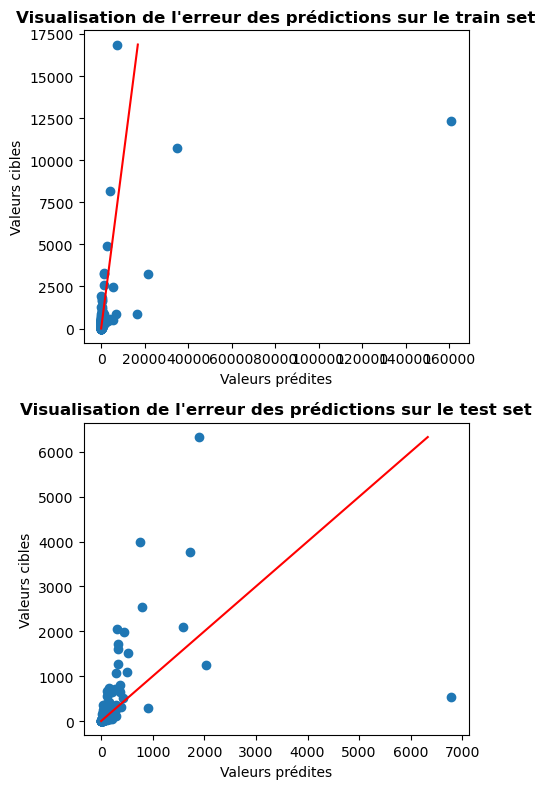

In [30]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_lasso_train, y_train_log, y_pred_lasso_test, y_test_log)

### 3.5 Elastic net <a class="anchor" id="3_5"></a>

In [31]:
# Déterminons le paramètre alpha qui va contrôler le paramètre de régularisation (on va en tester 50)
# Ils seront sur une échelle logarithmique
alphas = np.logspace(-5, 5, 50)

# Créer un dictionnaire de paramètres
params = {
    'elasticnet__alpha': alphas, 
    'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'elasticnet__precompute': [True, False],
    'elasticnet__selection': ['cyclic', 'random']
}

# utilisation de la fonction 'final_pipeline'
elastic_net = final_pipeline(X, ElasticNet(random_state=0), params)

# Entraînement du modèle
elastic_net.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                         'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'elasticnet__precompute': [True, False],
                         'elasticnet__selection': ['cyclic', 'random']},
             scoring='r2')

In [32]:
# Prédictions
y_pred_elastic_net_train = elastic_net.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_elastic_net_test = elastic_net.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
elastic_net_time = time.time() - start_time

In [33]:
affichage_résultats(elastic_net)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elasticnet__alpha,param_elasticnet__l1_ratio,param_elasticnet__precompute,param_elasticnet__selection,params,mean_test_score,std_test_score,rank_test_score
295,0.095621,0.008335,0.004401,4.902518e-04,0.007197,0.75,False,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611657,0.029550,1
293,0.096222,0.004957,0.004601,4.899598e-04,0.007197,0.75,True,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611657,0.029550,1
294,0.021405,0.002871,0.004201,4.001141e-04,0.007197,0.75,False,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611633,0.029553,3
292,0.021405,0.003879,0.004801,3.998996e-04,0.007197,0.75,True,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611633,0.029553,3
297,0.087820,0.013779,0.007202,3.919982e-03,0.007197,1,True,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611519,0.028670,5
299,0.079818,0.006243,0.005001,6.327867e-04,0.007197,1,False,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611519,0.028670,5
296,0.020404,0.001960,0.004601,4.901155e-04,0.007197,1,True,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611501,0.028675,7
298,0.019804,0.003125,0.004601,8.000374e-04,0.007197,1,False,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.611501,0.028675,7
279,0.130029,0.008027,0.004601,4.899014e-04,0.004498,1,False,random,"{'elasticnet__alpha': 0.004498432668969444, 'e...",0.611497,0.029791,9
277,0.129229,0.008752,0.005001,2.336015e-07,0.004498,1,True,random,"{'elasticnet__alpha': 0.004498432668969444, 'e...",0.611497,0.029791,9


In [34]:
# Affichage des scores
score(elastic_net, X_train, y_train_log, X_test, y_test_log, 
      'Elactic Net', elastic_net_time, df_results)

df_results.loc[df_results['Model'] == 'Elactic Net']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
4,Elactic Net,0.65,0.67,153.69,564.34,0.004001


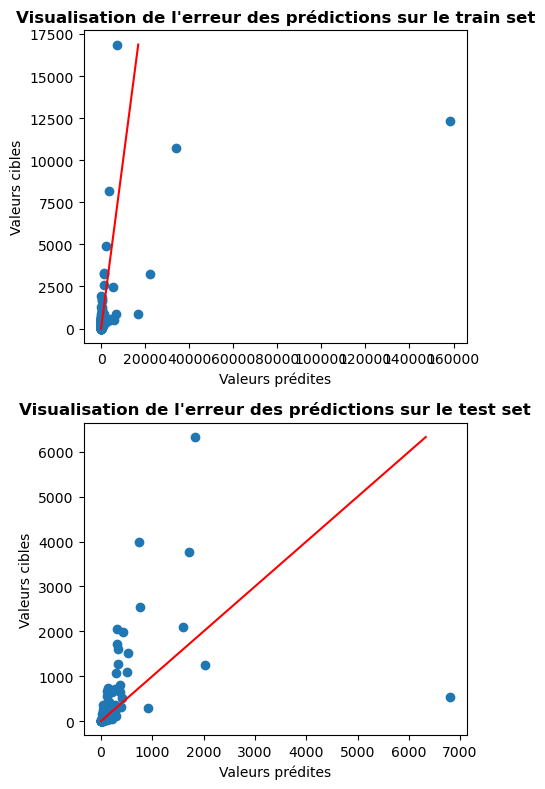

In [35]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_elastic_net_train, y_train_log, y_pred_elastic_net_test, y_test_log)

### 3.6 Linear SVR <a class="anchor" id="3_6"></a>

In [36]:
# Créer un dictionnaire de paramètres
params = {
    'linearsvr__max_iter': [1000, 10000, 50000, 100000],
    'linearsvr__C': np.logspace(-3, 3, 10),
    'linearsvr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'linearsvr__epsilon': [0.1, 0.2, 0.5, 0.9]
}

# utilisation de la fonction 'final_pipeline'
linear_svr = final_pipeline(X, LinearSVR(), params)

# Entraînement du modèle
linear_svr.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
             param_grid={'linearsvr__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'linearsvr__epsilon': [0.1, 0.2, 0.5, 0.9],
                         'linearsvr__loss': ['epsilon_insensitive',
                                             'squared_epsilon_insensitive'],
                         'linearsvr__max_iter': [1000, 10000, 50000, 100000]},
             scoring='r2')

In [37]:
# Prédictions
y_pred_linear_svr_train = linear_svr.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_linear_svr_test = linear_svr.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
linear_svr_execution_time = time.time() - start_time

In [38]:
affichage_résultats(linear_svr)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_linearsvr__epsilon,param_linearsvr__loss,param_linearsvr__max_iter,params,mean_test_score,std_test_score,rank_test_score
103,0.024805,0.001939,0.005401,4.897457e-04,0.1,0.1,squared_epsilon_insensitive,100000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606784,0.029305,1
100,0.021205,0.003545,0.006402,2.416923e-03,0.1,0.1,squared_epsilon_insensitive,1000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606781,0.029299,2
101,0.030007,0.007774,0.005801,4.000426e-04,0.1,0.1,squared_epsilon_insensitive,10000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606775,0.029303,3
102,0.022205,0.003312,0.005801,4.004241e-04,0.1,0.1,squared_epsilon_insensitive,50000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606770,0.029300,4
109,0.022605,0.001357,0.005601,4.900961e-04,0.1,0.2,squared_epsilon_insensitive,10000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606743,0.028002,5
110,0.024405,0.002654,0.006001,3.162980e-07,0.1,0.2,squared_epsilon_insensitive,50000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606741,0.028009,6
108,0.021604,0.002417,0.005602,4.901938e-04,0.1,0.2,squared_epsilon_insensitive,1000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606739,0.028007,7
111,0.023605,0.002333,0.005201,7.484939e-04,0.1,0.2,squared_epsilon_insensitive,100000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.606738,0.027993,8
118,0.021405,0.005315,0.005602,4.904464e-04,0.1,0.5,squared_epsilon_insensitive,50000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.604061,0.025998,9
116,0.020204,0.002040,0.005601,4.899987e-04,0.1,0.5,squared_epsilon_insensitive,1000,"{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0....",0.604061,0.025990,10


In [39]:
bestParams(linear_svr)

Les meilleurs paramètres sont :
{'linearsvr__C': 0.1, 'linearsvr__epsilon': 0.1, 'linearsvr__loss': 'squared_epsilon_insensitive', 'linearsvr__max_iter': 100000}


In [40]:
# Affichage des scores
score(linear_svr, X_train, y_train_log, X_test, y_test_log, 
      'Linear SVR', linear_svr_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Linear SVR']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
5,Linear SVR,0.66,0.67,152.88,555.39,0.003


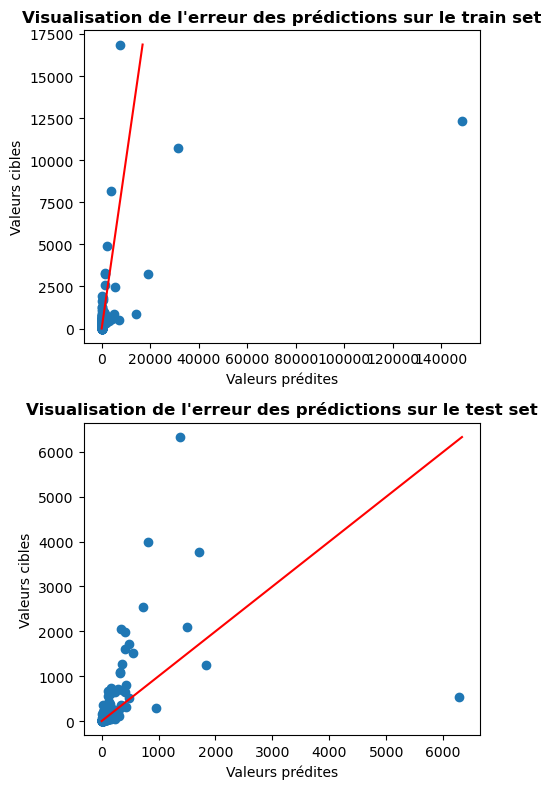

In [41]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_linear_svr_train, y_train_log, y_pred_linear_svr_test, y_test_log)

### 3.7 Forêts aléatoires <a class="anchor" id="3_7"></a>

In [42]:
# Créer un dictionnaire de paramètres
params = {
    'randomforestregressor__n_estimators': [100, 200, 300, 500, 1000],
    'randomforestregressor__max_depth': [3, 4, 5, 6, 7, 8, 9]
}

# utilisation de la fonction 'final_pipeline'
random_forest = final_pipeline(X, RandomForestRegressor(), params)

# Entraînement du modèle
random_forest.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA',
                                                                          'EraBuild',
                                                                          'SteamUse_Ratio',
                                                                          'ElectricityUse_Ratio',
                                                                          'NaturalGasUse_Ratio'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [3, 4, 5, 6, 7, 8,
                                                              9],
                         'randomforestregressor__n_estimators': [100, 200, 300,
                                                                 500, 1000]},
             scoring='r2')

In [43]:
# Prédictions
y_pred_random_forest_train = random_forest.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_random_forest_test = random_forest.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
random_forest_execution_time = time.time() - start_time

In [44]:
affichage_résultats(random_forest)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,params,mean_test_score,std_test_score,rank_test_score
32,4.339579,0.133112,0.030807,0.001167,9,300,"{'randomforestregressor__max_depth': 9, 'rando...",0.741323,0.034912,1
34,9.866514,0.445596,0.060613,0.000800,9,1000,"{'randomforestregressor__max_depth': 9, 'rando...",0.740652,0.035596,2
30,1.415119,0.021165,0.013203,0.000400,9,100,"{'randomforestregressor__max_depth': 9, 'rando...",0.739324,0.035321,3
33,6.666503,0.191931,0.040009,0.005551,9,500,"{'randomforestregressor__max_depth': 9, 'rando...",0.739045,0.036662,4
29,11.609818,0.218224,0.073417,0.011777,8,1000,"{'randomforestregressor__max_depth': 8, 'rando...",0.738058,0.036029,5
27,3.526995,0.057634,0.029406,0.001020,8,300,"{'randomforestregressor__max_depth': 8, 'rando...",0.737967,0.035284,6
31,2.838840,0.052378,0.023005,0.001414,9,200,"{'randomforestregressor__max_depth': 9, 'rando...",0.737559,0.037217,7
26,2.430348,0.065064,0.020805,0.000400,8,200,"{'randomforestregressor__max_depth': 8, 'rando...",0.736967,0.035786,8
28,5.893729,0.094231,0.052412,0.015309,8,500,"{'randomforestregressor__max_depth': 8, 'rando...",0.736908,0.035870,9
25,1.189068,0.012010,0.012803,0.000400,8,100,"{'randomforestregressor__max_depth': 8, 'rando...",0.735437,0.033481,10


In [45]:
bestParams(random_forest)

Les meilleurs paramètres sont :
{'randomforestregressor__max_depth': 9, 'randomforestregressor__n_estimators': 300}


In [46]:
# Affichage des scores
score(random_forest, X_train, y_train_log, X_test, y_test_log, 
      'Random Forest', random_forest_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Random Forest']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
6,Random Forest,0.92,0.82,104.1,335.6,0.022005


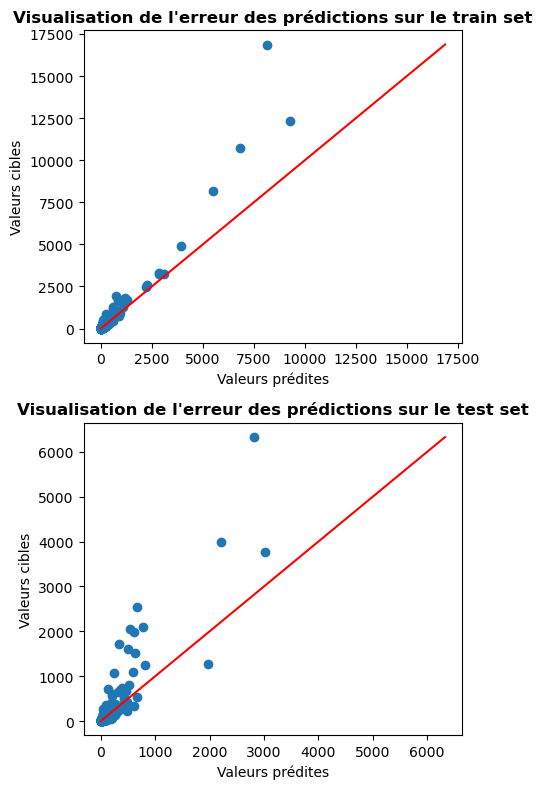

In [47]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_random_forest_train, y_train_log, y_pred_random_forest_test, y_test_log)

### 3.8  XGBoost <a class="anchor" id="3_8"></a>

In [48]:
# Créer un dictionnaire de paramètres
params = {
    'xgbregressor__n_estimators': [100, 200, 300, 500],
    'xgbregressor__max_depth': [3, 4, 5, 6, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__gamma': [0, 0.05, 0.1, 0.2]
}

# utilisation de la fonction 'final_pipeline'
xgboost = final_pipeline(X, XGBRegressor(), params)

# Entraînement du modèle
xgboost.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__gamma': [0, 0.05, 0.1, 0.2],
                         'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
                         'xgbregressor__max_depth': [3, 4, 5, 6, 7],
                         'xgbregressor__n_estimators': [100, 200, 300, 500]},
             scoring='r2')

In [49]:
# Prédictions
y_pred_xgboost_train = xgboost.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_xgboost_test = xgboost.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
xgboost_execution_time = time.time() - start_time

In [50]:
affichage_résultats(xgboost)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__gamma,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,mean_test_score,std_test_score,rank_test_score
201,0.097222,0.004022,0.008802,7.485067e-04,0.2,0.1,3,200,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.774972,0.026294,1
203,0.141231,0.005270,0.008002,3.234067e-07,0.2,0.1,3,500,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.774972,0.026293,2
202,0.108024,0.003407,0.008202,4.000905e-04,0.2,0.1,3,300,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.774972,0.026293,3
141,0.109825,0.002401,0.009002,1.095975e-03,0.1,0.1,3,200,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.772954,0.026869,4
143,0.178440,0.014722,0.011203,5.419727e-03,0.1,0.1,3,500,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.771756,0.026571,5
142,0.140231,0.020668,0.009002,6.324854e-04,0.1,0.1,3,300,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.771756,0.026571,6
200,0.073617,0.004802,0.009802,1.166025e-03,0.2,0.1,3,100,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.771460,0.027272,7
21,0.114026,0.005293,0.008803,7.478950e-04,0,0.1,3,200,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.770521,0.028256,8
80,0.067816,0.003868,0.008802,3.990183e-04,0.05,0.1,3,100,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.770444,0.028549,9
140,0.068415,0.004318,0.008403,1.021011e-03,0.1,0.1,3,100,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.770379,0.028213,10


In [51]:
bestParams(xgboost)

Les meilleurs paramètres sont :
{'xgbregressor__gamma': 0.2, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 200}


In [52]:
# Affichage des scores
score(xgboost, X_train, y_train_log, X_test, y_test_log, 
      'XGBoost', xgboost_execution_time, df_results)

df_results.loc[df_results['Model'] == 'XGBoost']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
7,XGBoost,0.88,0.84,100.79,316.5,0.004001


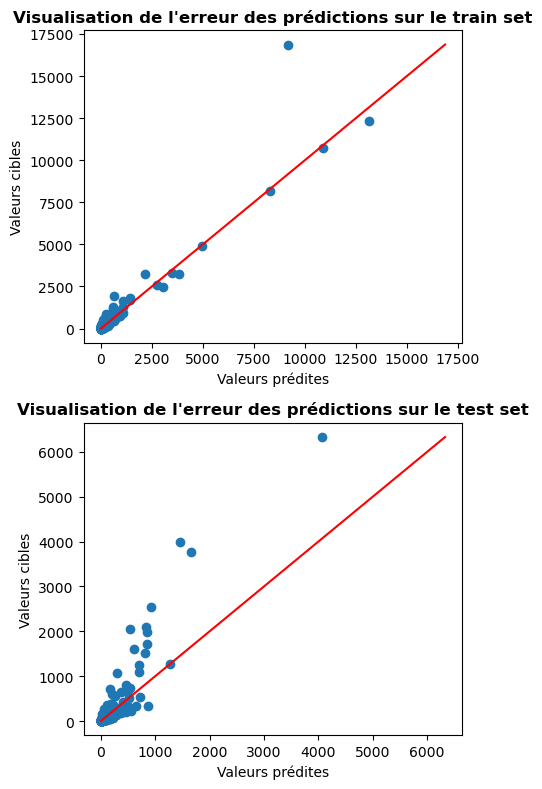

In [53]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_xgboost_train, y_train_log, y_pred_xgboost_test, y_test_log)

## 4. Choix du modèle <a class="anchor" id="4"></a>

### 4.1  Affichage des scores <a class="anchor" id="4_1"></a>

In [54]:
df_results = df_results.sort_values('R2_test', ascending=True)
df_results

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
0,Dummy Regressor,-0.00,-0.01,188.14,600.15,0.003001
1,Linear Regression,0.66,0.67,152.00,563.46,0.003000
2,Ridge,0.66,0.67,154.07,571.87,0.003001
4,Elactic Net,0.65,0.67,153.69,564.34,0.004001
5,Linear SVR,0.66,0.67,152.88,555.39,0.003000
3,Lasso,0.65,0.68,153.17,561.47,0.002001
6,Random Forest,0.92,0.82,104.10,335.60,0.022005
7,XGBoost,0.88,0.84,100.79,316.50,0.004001


### 4.2  Comparaison des scores obtenus <a class="anchor" id="4_2"></a>

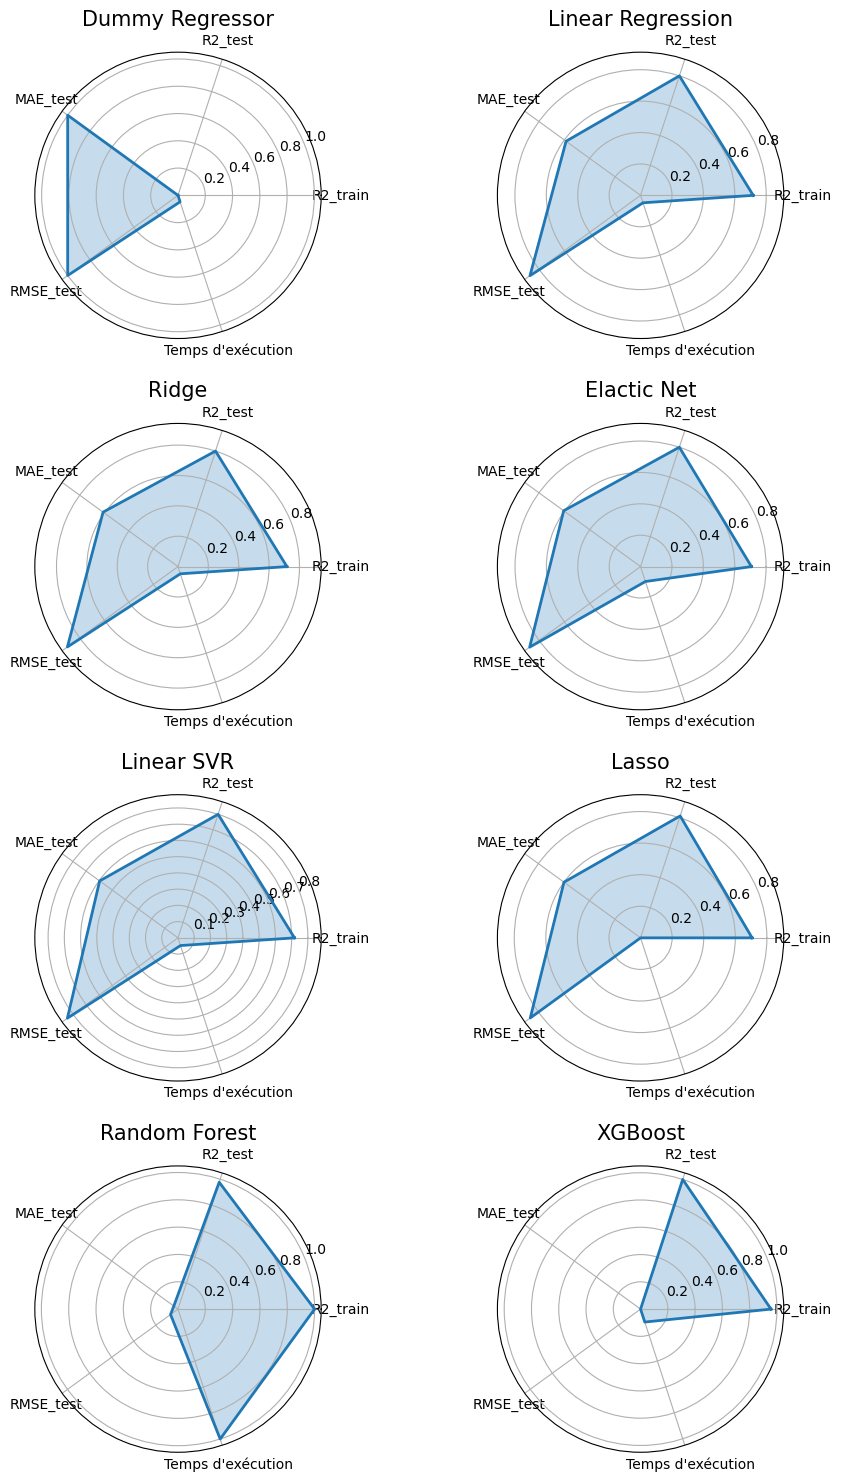

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Exclure la colonne 'Model' pour la normalisation
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_results.iloc[:, 1:])

# Création du radar plot
angles = np.linspace(0, 2 * np.pi, len(df_results.columns)-1, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Création des 4x2 radars plots pour chaque modèle
fig, axes = plt.subplots(4, 2, figsize=(12, 15), subplot_kw={'polar': True})
fig.subplots_adjust(wspace=0, hspace=2)

for i, ax in enumerate(axes.flatten()):  # Utilisez .flatten() pour parcourir les sous-axes
    # Sélection des valeurs normalisées des caractéristiques pour le modèle i
    values = normalized_values[i]  # Exclut la première colonne (Model)
    values = np.concatenate((values, [values[0]]))
    model_name = df_results.iloc[i]['Model']
    # Tracé du radar plot pour le modèle i
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(df_results.columns[1:], fontsize=10)
    ax.set_title(model_name, fontsize=15)

plt.tight_layout()
plt.show()

### 4.3  Comparaison par le coefficient de détermination <a class="anchor" id="4_3"></a>

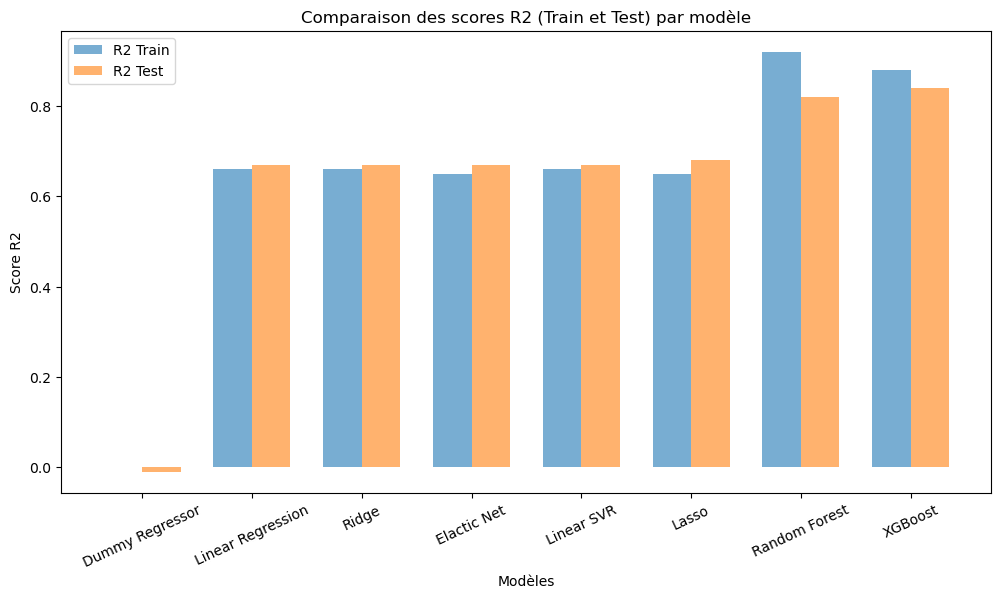

In [56]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Model']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Largeur des barres
bar_width = 0.35

# Tracer les scores R2 d'entraînement et de test côte à côte
train_bars = ax.bar(model_indices - bar_width/2, df_results['R2_train'], bar_width, label='R2 Train', alpha=0.6)
test_bars = ax.bar(model_indices + bar_width/2, df_results['R2_test'], bar_width, label='R2 Test', alpha=0.6)

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Score R2')
ax.set_title('Comparaison des scores R2 (Train et Test) par modèle')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Model'], rotation=25)
ax.legend()
plt.show()

### 4.4  Comparaison par l'erreur <a class="anchor" id="4_4"></a>

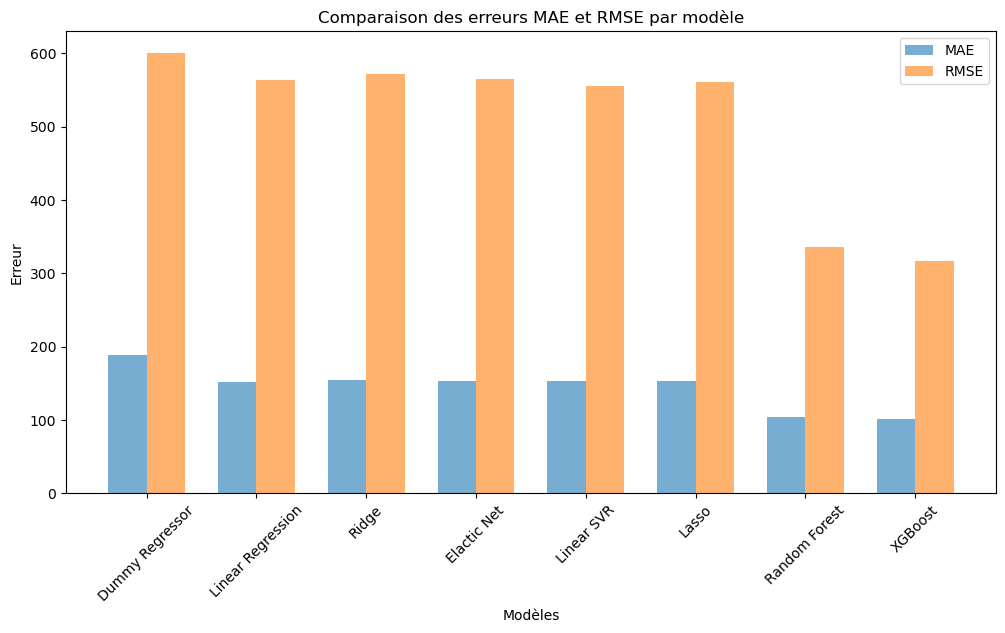

In [57]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Model']))

# Largeur des barres
bar_width = 0.35

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les erreurs MAE et RMSE côte à côte pour chaque modèle
mae_bars = ax.bar(model_indices - bar_width/2, df_results['MAE_test'], bar_width, label='MAE', alpha=0.6)
rmse_bars = ax.bar(model_indices + bar_width/2, df_results['RMSE_test'], bar_width, label='RMSE', alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Erreur')
ax.set_title('Comparaison des erreurs MAE et RMSE par modèle')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Model'], rotation=45)
ax.legend()
plt.show()

### 4.5  Comparaison par le temps d'exécution <a class="anchor" id="4_5"></a>

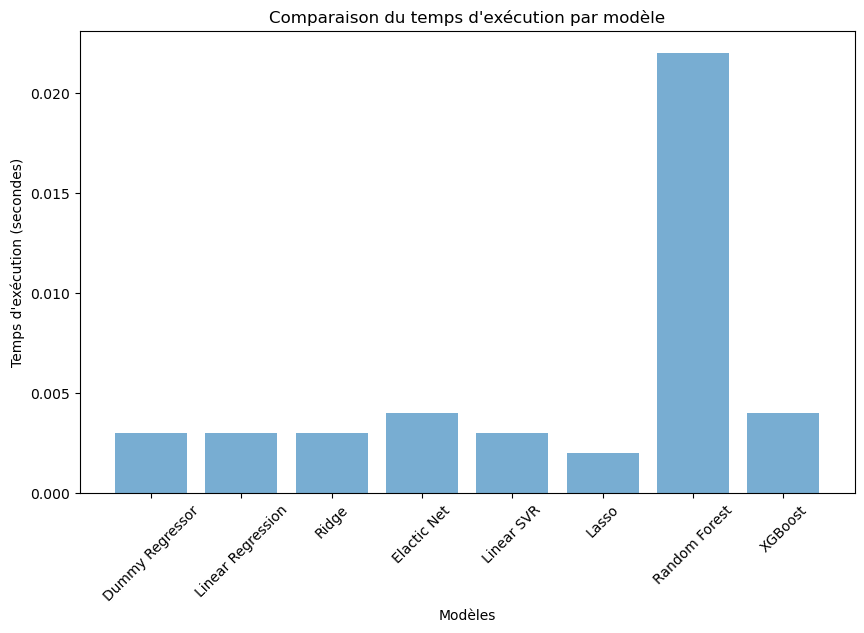

In [58]:
# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le temps d'exécution pour chaque modèle
ax.bar(df_results['Model'], df_results["Temps d'exécution"], label='Temps d\'exécution', alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel("Temps d'exécution (secondes)")
ax.set_title("Comparaison du temps d'exécution par modèle")

# Afficher le graphique
plt.xticks(rotation=45)
plt.show()

Nous choisirons donc le modèle de boosting : XGBoost regressor.

Celui-ci nous permet de maximiser le coefficient de détermination R2, de diminuer le plus possible l'erreur et de minimiser le temps d'exécution. 

### 4.6  Courbe d'apprentissage sur le XGBoost <a class="anchor" id="4_6"></a>

Nombre de données par lot :
[  55  171  287  403  519  636  752  868  984 1101]


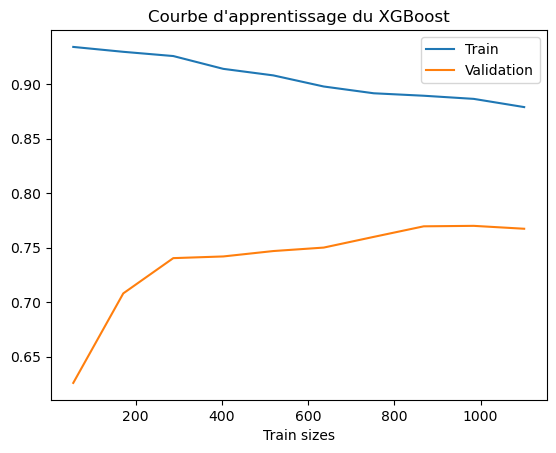

In [59]:
# Traçons la courbe d'apprentissage et le score de validation croisé associé
N, train_score, val_score = learning_curve(xgboost.best_estimator_, X_train, y_train_log,
                            train_sizes= np.linspace(0.05, 1.0, 10), cv=15)

print('Nombre de données par lot :')
print(N)
plt.plot(N, train_score.mean(axis=1), label='Train')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.xlabel('Train sizes')
plt.title("Courbe d'apprentissage du XGBoost")
plt.legend()
plt.show()

On peut voir ici que rajouter des données d'entraînement n'améliorera pas notre modèle.

## 5. Evaluation de l'intérêt de l'ENERGY STAR score pour la prédiction <a class="anchor" id="5"></a>

### 5.1 Preprocessing <a class="anchor" id="5_1"></a>

In [60]:
df_energy = df.dropna()
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              960 non-null    object 
 1   Neighborhood                     960 non-null    object 
 2   NumberofBuildings                960 non-null    float64
 3   NumberofFloors                   960 non-null    int64  
 4   PropertyGFATotal                 960 non-null    int64  
 5   PropertyGFAParking               960 non-null    int64  
 6   LargestPropertyUseType           960 non-null    object 
 7   LargestPropertyUseTypeGFA        960 non-null    float64
 8   SecondLargestPropertyUseType     960 non-null    object 
 9   SecondLargestPropertyUseTypeGFA  960 non-null    float64
 10  ThirdLargestPropertyUseType      960 non-null    object 
 11  ThirdLargestPropertyUseTypeGFA   960 non-null    float64
 12  ENERGYSTARScore      

In [61]:
# Instancier X et y
X_energy = df_energy.drop(['TARGET_SiteEnergyUse(kBtu)', 'TARGET_TotalGHGEmissions'], axis=1)
y_energy = df_energy['TARGET_TotalGHGEmissions']

# Mettre y au log
log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
y_energy_log = log_transformer.transform(y_energy)

In [62]:
# On divise notre train set et test set
X_energy_train, X_energy_test, y_energy_log_train, y_energy_log_test = \
train_test_split(X_energy, y_energy_log, train_size=0.8, random_state=0)

# Vérifions la taille de notre train set et de notre test set
print(f'Nous avons X_energy_train de forme {X_energy_train.shape} et y_energy_log_train de forme {y_energy_log_train.shape}.')
print()
print(f'Nous avons X_energy_test de forme {X_energy_test.shape} et y_energy_log_test de forme {y_energy_log_test.shape}.')

Nous avons X_energy_train de forme (768, 17) et y_energy_log_train de forme (768,).

Nous avons X_energy_test de forme (192, 17) et y_energy_log_test de forme (192,).


### 5.2 Modélisation du XGBoost avec l'ENERGY STAR score  <a class="anchor" id="5_2"></a>

In [63]:
# Créer un dictionnaire de paramètres
params = {
    'xgbregressor__n_estimators': [100, 200, 300, 500],
    'xgbregressor__max_depth': [3, 4, 5, 6, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__gamma': [0, 0.05, 0.1, 0.2]
}

# utilisation de la fonction 'final_pipeline'
xgboost_ENERGY = final_pipeline(X_energy, XGBRegressor(), params)

# Entraînement du modèle
xgboost_ENERGY.fit(X_energy_train , y_energy_log_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__gamma': [0, 0.05, 0.1, 0.2],
                         'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
                         'xgbregressor__max_depth': [3, 4, 5, 6, 7],
                         'xgbregressor__n_estimators': [100, 200, 300, 500]},
             scoring='r2')

In [64]:
# Prédictions
y_pred_xgboost_energy_train = xgboost_ENERGY.best_estimator_.predict(X_energy_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_xgboost_energy_test = xgboost_ENERGY.best_estimator_.predict(X_energy_test )

# Calcul du temps d'exécution
xgboost_energy_execution_time = time.time() - start_time

In [65]:
affichage_résultats(xgboost_ENERGY)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__gamma,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,mean_test_score,std_test_score,rank_test_score
22,0.139031,0.001898,0.008202,0.00040,0,0.1,3,300,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.888206,0.010190,1
103,0.111025,0.002281,0.006802,0.00040,0.05,0.2,3,500,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.888004,0.007393,2
102,0.082819,0.002401,0.006401,0.00049,0.05,0.2,3,300,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.888004,0.007393,3
101,0.069015,0.002967,0.006202,0.00040,0.05,0.2,3,200,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.888004,0.007393,4
100,0.055612,0.002728,0.006601,0.00080,0.05,0.2,3,100,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.887822,0.007123,5
21,0.101423,0.003073,0.008402,0.00049,0,0.1,3,200,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.886847,0.010226,6
81,0.105623,0.016234,0.007601,0.00080,0.05,0.1,3,200,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.886530,0.009796,7
83,0.142832,0.008378,0.007402,0.00049,0.05,0.1,3,500,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.886529,0.009796,8
82,0.113225,0.004623,0.007402,0.00049,0.05,0.1,3,300,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.886529,0.009796,9
23,0.222249,0.002858,0.008802,0.00040,0,0.1,3,500,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.886206,0.010672,10


In [66]:
bestParams(xgboost_ENERGY)

Les meilleurs paramètres sont :
{'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 300}


In [67]:
# Affichage des scores
score(xgboost_ENERGY, X_energy_train, y_energy_log_train, X_energy_test, y_energy_log_test, 
      'XGBoost_ENERGY', xgboost_energy_execution_time, df_results)

df_results.loc[df_results['Model'] == 'XGBoost_ENERGY']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
8,XGBoost_ENERGY,0.98,0.86,67.84,345.58,0.005001


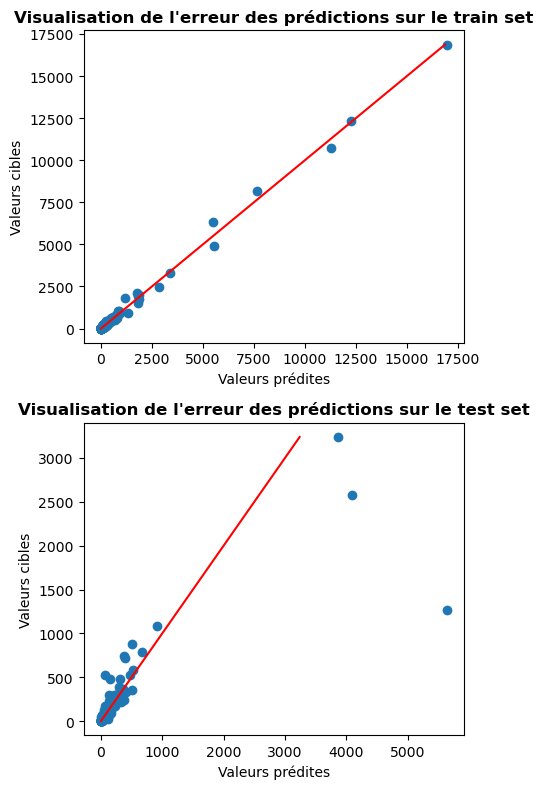

In [68]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_xgboost_energy_train, y_energy_log_train, y_pred_xgboost_energy_test, y_energy_log_test)

Nombre de données par lot :
[ 35 111 186 262 338 413 489 564 640 716]


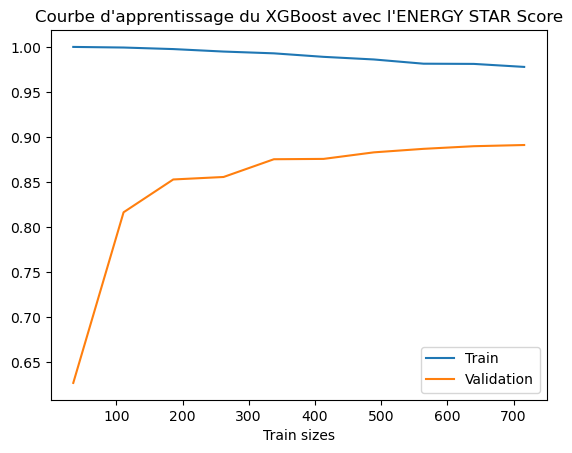

In [69]:
# Traçons la courbe d'apprentissage et le score de validation croisé associé
N, train_score, val_score = learning_curve(xgboost_ENERGY.best_estimator_, X_energy_train, y_energy_log_train,
                            train_sizes= np.linspace(0.05, 1.0, 10), cv=15)

print('Nombre de données par lot :')
print(N)
plt.plot(N, train_score.mean(axis=1), label='Train')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.xlabel('Train sizes')
plt.title("Courbe d'apprentissage du XGBoost avec l'ENERGY STAR Score")
plt.legend()
plt.show()

### 5.3 Comparaison des scores avec ou sans ENERGY STAR score  <a class="anchor" id="5_3"></a>

In [70]:
df_results.loc[df_results['Model'].isin(['XGBoost', 'XGBoost_ENERGY'])]

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
7,XGBoost,0.88,0.84,100.79,316.50,0.004001
8,XGBoost_ENERGY,0.98,0.86,67.84,345.58,0.005001


Le score est amélioré, on peut donc en conclure que l'ENERGY STAR Score a un intérêt dans la prédiction des émissions de CO2.

Le modèle final prendra donc en compte l'ENERGY STAR Score.

## 6. Importance des caractéristiques (Features importance) <a class="anchor" id="6"></a>

###### SHAP (Shapley Additive explanations)

In [71]:
# Variables qualitatives
variables_qualitatives = X.select_dtypes(['object','bool']).columns.to_list()

# Variables quantitatives avec l'energy star score
variables_quantitatives_energy = X_energy.select_dtypes(['int64','float64']).columns.to_list()

# Preprocessing des données
quantitatif_scaler = StandardScaler()
qualitatif_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
transformers = [('qualitatif', qualitatif_encoder, variables_qualitatives), 
                ('quantitatif', quantitatif_scaler, variables_quantitatives_energy)]
preparation = ColumnTransformer(transformers)

# On entraine sur les données du train set
preparation.fit(X_energy_train)

# On applique le preprocessing aux données du test set
X_energy_test_preprocessed = preparation.transform(X_energy_test)

In [72]:
# On prend les meilleurs paramètres de la grid
model_energy = xgboost_ENERGY.best_estimator_.named_steps['xgbregressor']

# On créé un shap.sample pour diminuer le temps d'exécution
train_energy_summary = shap.sample(preparation.transform(X_energy_train), 100)

# Contexte de parallélisme pour l'exploration SHAP
with parallel_backend('threading', n_jobs=-1):

    # Explainer SHAP
    explainer = shap.KernelExplainer(model_energy.predict, train_energy_summary)

    # Prédiction des valeurs pour X_test_preprocessed
    y_pred = model_energy.predict(X_energy_test_preprocessed)

    # Calcul des valeurs SHAP
    shap_values = explainer.shap_values(X_energy_test_preprocessed)

  0%|          | 0/192 [00:00<?, ?it/s]

In [73]:
# Noms des features
column_names = \
list(preparation\
     .named_transformers_['qualitatif']\
     .get_feature_names_out(input_features=variables_qualitatives)) \
+ list(preparation\
       .named_transformers_['quantitatif']\
       .get_feature_names_out(input_features=variables_quantitatives_energy))

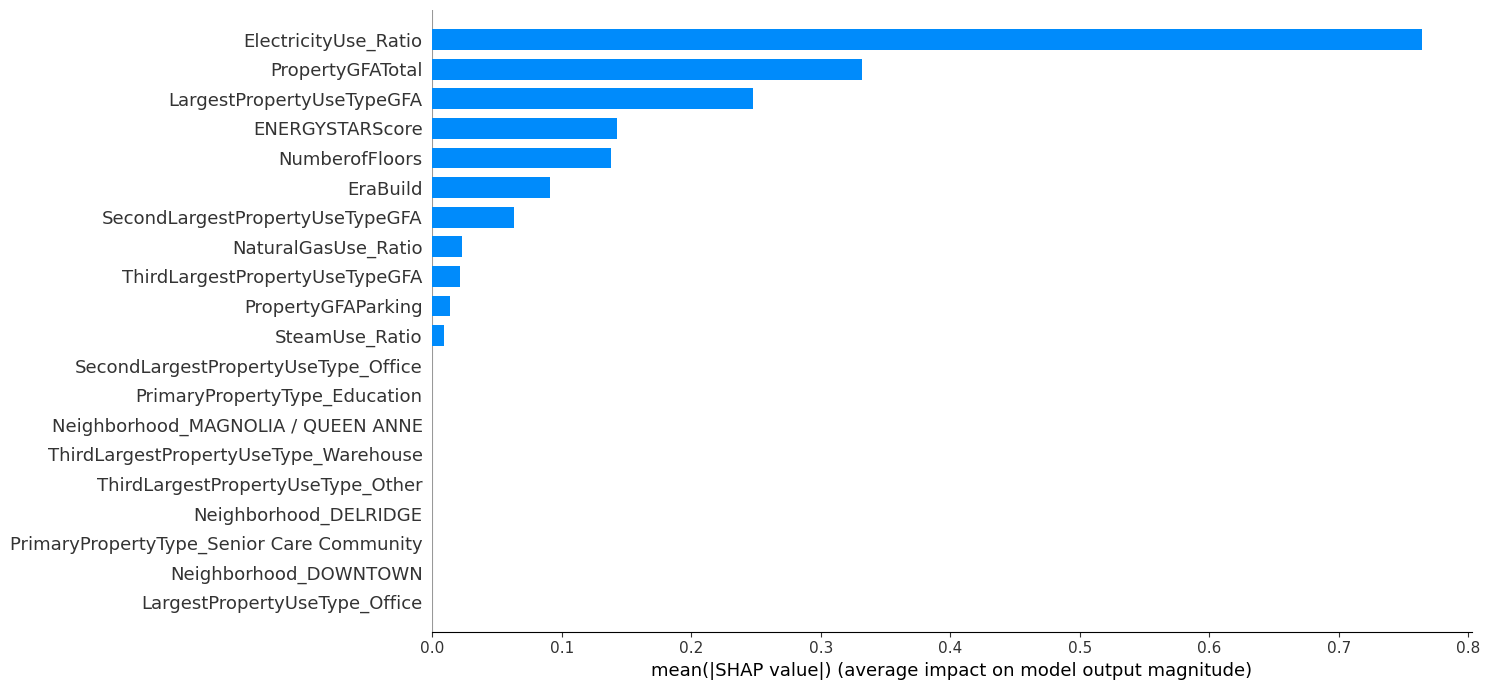

In [74]:
# Affichez le graphique d'importance des caractéristiques
shap.summary_plot(shap_values, 
                  X_energy_test_preprocessed, 
                  plot_type="bar", 
                  feature_names = column_names, 
                  plot_size=(15,7))

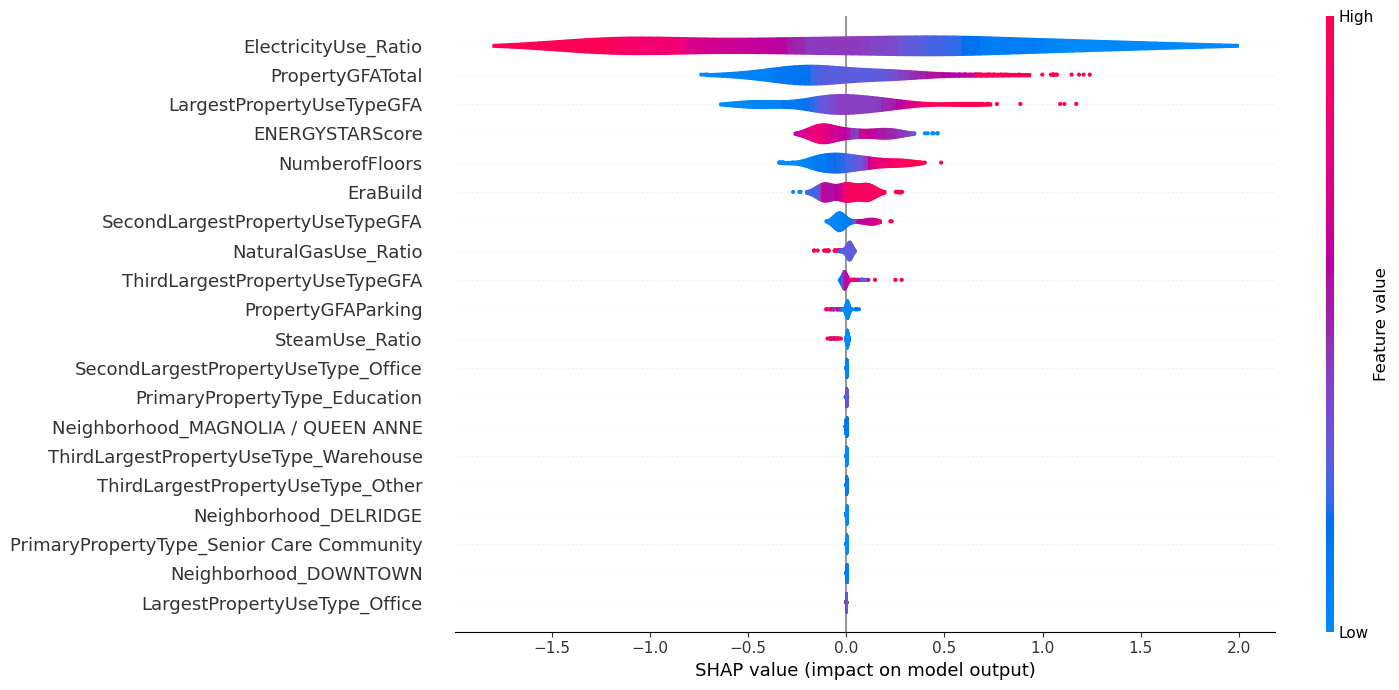

In [75]:
# Affichez le graphique d'importance des caractéristiques
shap.summary_plot(shap_values, 
                  X_energy_test_preprocessed, 
                  plot_type="violin", 
                  feature_names = column_names, 
                  plot_size=(15,7))

Ici on peut voir que lorsque l'ElectricityUse_Ratio est élevé cela à un impact négatif sur le modèle.

Donc plus le bâtiments utilise de l'électricité est moins il émet de CO2.

## 7. Enregistrement du modèle <a class="anchor" id="7"></a>

In [76]:
# Sauvegarder le modèle XGBoost entraîné avec l'ENERGY STAR Score dans un fichier pickle
with open('Prediction_emissions_CO2.pickle', 'wb') as file:
    pickle.dump(xgboost_ENERGY.best_estimator_, file)